In [1]:
import numpy as np
import pandas as pd
#Create X and y vectors for sklearn pre-processing steps
df = pd.read_csv('data/pop_merge.csv')

#Remove years before 1992, which is the year of the split between Winter and Summer Olympics
df = df.loc[df['Year'] >= 2010]
df = df.sample(n = 2000, random_state = 1)


y=df['Sport']
X=df.drop(['Sport', 'Unnamed: 0','Event'], axis = 1)

print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 106876 to 165860
Data columns (total 11 columns):
Country            2000 non-null object
Sex                2000 non-null int64
Age                2000 non-null int64
Height             2000 non-null int64
Weight             2000 non-null int64
Year               2000 non-null int64
Season             2000 non-null int64
BMI                2000 non-null float64
Population_Prop    2000 non-null float64
Medal              2000 non-null int64
Previous_Medals    2000 non-null int64
dtypes: float64(2), int64(8), object(1)
memory usage: 187.5+ KB
None


In [2]:
X = pd.get_dummies(X, columns = ['Country', 'Season','Sex'])

In [3]:
X = X[['Age', 'Height', 'Weight', 'Year', 'BMI', 'Population_Prop', 'Country_USA', 'Season_0', 'Season_1', 'Sex_0', 'Sex_1']]
print(X.describe())
print(y.describe())

               Age       Height       Weight         Year          BMI  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean     26.110000   175.853000    71.470500  2013.524000    22.890782   
std       5.487983    10.858561    15.815916     2.192676     3.288332   
min      14.000000   137.000000    35.000000  2010.000000    15.765056   
25%      22.000000   168.000000    60.000000  2012.000000    20.796730   
50%      26.000000   175.000000    69.000000  2014.000000    22.432303   
75%      29.000000   183.000000    80.000000  2016.000000    24.396810   
max      56.000000   215.000000   170.000000  2016.000000    48.326531   

       Population_Prop  Country_USA     Season_0     Season_1        Sex_0  \
count      2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean          0.017852     0.058500     0.276000     0.724000     0.459000   
std           0.038418     0.234745     0.447129     0.447129     0.498441   
min           0.00000

In [4]:
print('There are %d unique sports in y: ' % len(y.unique()))
print(y.unique())

There are 49 unique sports in y: 
['Fencing' 'Athletics' 'Alpine Skiing' 'Cycling' 'Gymnastics' 'Volleyball'
 'Ice Hockey' 'Judo' 'Canoeing' 'Curling' 'Swimming' 'Table Tennis'
 'Shooting' 'Synchronized Swimming' 'Freestyle Skiing' 'Rowing' 'Hockey'
 'Snowboarding' 'Biathlon' 'Badminton' 'Football' 'Cross Country Skiing'
 'Rugby Sevens' 'Taekwondo' 'Speed Skating' 'Bobsleigh' 'Diving'
 'Handball' 'Equestrianism' 'Sailing' 'Archery'
 'Short Track Speed Skating' 'Water Polo' 'Rhythmic Gymnastics' 'Golf'
 'Basketball' 'Figure Skating' 'Weightlifting' 'Wrestling' 'Ski Jumping'
 'Luge' 'Boxing' 'Nordic Combined' 'Tennis' 'Beach Volleyball' 'Skeleton'
 'Triathlon' 'Trampolining' 'Modern Pentathlon']


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc=le.fit_transform(y)
print(y_enc)
print(le.classes_)

[15  2  0 ... 14 47 20]
['Alpine Skiing' 'Archery' 'Athletics' 'Badminton' 'Basketball'
 'Beach Volleyball' 'Biathlon' 'Bobsleigh' 'Boxing' 'Canoeing'
 'Cross Country Skiing' 'Curling' 'Cycling' 'Diving' 'Equestrianism'
 'Fencing' 'Figure Skating' 'Football' 'Freestyle Skiing' 'Golf'
 'Gymnastics' 'Handball' 'Hockey' 'Ice Hockey' 'Judo' 'Luge'
 'Modern Pentathlon' 'Nordic Combined' 'Rhythmic Gymnastics' 'Rowing'
 'Rugby Sevens' 'Sailing' 'Shooting' 'Short Track Speed Skating'
 'Skeleton' 'Ski Jumping' 'Snowboarding' 'Speed Skating' 'Swimming'
 'Synchronized Swimming' 'Table Tennis' 'Taekwondo' 'Tennis'
 'Trampolining' 'Triathlon' 'Volleyball' 'Water Polo' 'Weightlifting'
 'Wrestling']


In [6]:
from sklearn.preprocessing import StandardScaler
#Standardize X
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state=0)
for train_index, test_index in sss.split(X_std, y_enc):
    X_train, X_test = X_std[train_index], X_std[test_index]
    y_train, y_test = y_enc[train_index], y_enc[test_index]

In [8]:
from sklearn import metrics as mt
def per_class_accuracy(ytrue, yhat):
    conf = mt.confusion_matrix(ytrue, yhat)
    norm_conf = conf.diagonal() / conf.sum(axis=1)
    return norm_conf

def plot_class_acc(ytrue, yhat, title=''):
    acc_list = per_class_accuracy(ytrue, yhat)
    plt.bar(le.classes_, acc_list)
    plt.xlabel('Class value (One per Sport)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.xticks(rotation = 'vertical')
    plt.grid()
    plt.ylim([0,1])
    plt.show()

In [16]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Perform Grid Search to tune Hyperparamters of a Random Forest Classifier
# Determine best number of estimators
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 800, num = 7)]
# Max depth
max_depth =[10, 20, 50]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20]
# Creating the grid
param_grid = {'n_estimators' : n_estimators,
              'max_features': max_features,
              'max_depth' : max_depth,
              'min_samples_leaf': min_samples_leaf
              }

rf = RandomForestClassifier(random_state = 0, class_weight = 'balanced')
rfGS = GridSearchCV(estimator = rf, 
                    n_jobs = -1,
                    verbose = 1,
                    param_grid = param_grid, 
                    cv = 3,
                    scoring = 'accuracy')


#Perform hyperparameter search to find the best combination of parameters for our data
rfGS.fit(X_train, y_train)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


/Users/Steve/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed:  1.1min finished


CPU times: user 1.43 s, sys: 130 ms, total: 1.56 s
Wall time: 1min 6s


In [17]:
rfGS.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=450, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [18]:
%%time
# Perform Stratifed 10-fold cross-validation on the Random Forest Model
rf_clf = rfGS.best_estimator_

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs


The Random Forest accuracy is: 0.23


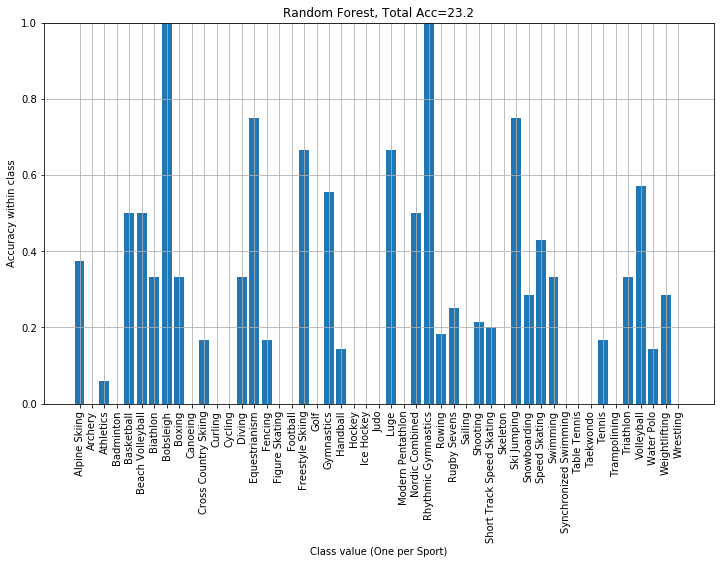

[0.375      0.         0.06       0.         0.5        0.5
 0.33333333 1.         0.33333333 0.         0.16666667 0.
 0.         0.33333333 0.75       0.16666667 0.         0.
 0.66666667 0.         0.55555556 0.14285714 0.         0.
 0.         0.66666667 0.         0.5        1.         0.18181818
 0.25       0.         0.21428571 0.2        0.         0.75
 0.28571429 0.42857143 0.33333333 0.         0.         0.
 0.16666667 0.         0.33333333 0.57142857 0.14285714 0.28571429
 0.        ]
CPU times: user 484 ms, sys: 19.9 ms, total: 504 ms
Wall time: 505 ms


In [19]:
%%time

from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 7)
from sklearn.metrics import classification_report

yhat = rf_clf.predict(X_test)
print('The Random Forest accuracy is: %.2f' % accuracy_score(y_test, yhat))

plot_class_acc(y_test, yhat, title='Random Forest')

print(per_class_accuracy(y_test, yhat))

In [20]:
rf_clf_model = rf_clf.fit(X_train, y_train)

In [21]:
from sklearn.externals import joblib 
joblib.dump(rf_clf_model, 'rf_finalized.joblib')

['rf_finalized.joblib']

In [22]:
rf_clf_model = joblib.load('rf_finalized.joblib')